In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

In [2]:
from catboost.utils import get_gpu_device_count
print("Available GPU count:", get_gpu_device_count())


Available GPU count: 1


In [3]:
df = pd.read_csv('data/ts2024.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='ISO8601')
hourly_index = pd.date_range(start=df['DateTime'].min(), end=df['DateTime'].max(), freq='H')
df['DateTime'] = hourly_index
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['DayOfMonth'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year


In [4]:

df = pd.read_csv('data/ts2024.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], format='ISO8601')
hourly_index = pd.date_range(start=df['DateTime'].min(), end=df['DateTime'].max(), freq='H')
df['DateTime'] = hourly_index
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['DayOfMonth'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year

df = df.set_index(hourly_index).rename_axis('date')



train = df[df['X'].notna()]  
test = df[df['X'].isna()]  



train2 = train[:-1000]
test = train[-1000:]

In [15]:
df = pd.DataFrame({'Date': train2.index, 'Value': train2.X})

lag = 1000  
for i in range(1, lag + 1):
    df[f'lag_{i}'] = df['Value'].shift(i)


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


feature_cols = [f'lag_{i}' for i in range(1, lag + 1)]
X = df[feature_cols].values    
y = df['Value'].values


model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=5,
                          task_type="GPU",
                          l2_leaf_reg=10,
                          devices='0',
                          verbose=100)
model.fit(X, y)





#predictions
n_forecast = len(test)  
predictions = [] 


last_value = df.iloc[-1]['Value']


last_features = X[-1]

forecast_input = np.concatenate(([last_value], last_features[:-1]))
current_input = forecast_input.copy()
for i in range(n_forecast):
    # Приводим current_input к форме (1, lag)
    pred = model.predict(current_input.reshape(1, -1))
    predictions.append(pred[0])

    current_input = np.concatenate(([pred[0]], current_input[:-1]))


last_date = df.iloc[-1]['Date']
future_dates = test.index

forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': predictions})

0:	learn: 0.0467422	total: 23.3ms	remaining: 23.3s
100:	learn: 0.0172770	total: 2.2s	remaining: 19.6s
200:	learn: 0.0157127	total: 4.36s	remaining: 17.3s
300:	learn: 0.0146512	total: 6.53s	remaining: 15.2s
400:	learn: 0.0137912	total: 8.68s	remaining: 13s
500:	learn: 0.0130098	total: 10.8s	remaining: 10.8s
600:	learn: 0.0123945	total: 13s	remaining: 8.64s
700:	learn: 0.0118216	total: 15.2s	remaining: 6.48s
800:	learn: 0.0113642	total: 17.3s	remaining: 4.31s
900:	learn: 0.0109083	total: 19.5s	remaining: 2.14s
999:	learn: 0.0105435	total: 21.6s	remaining: 0us


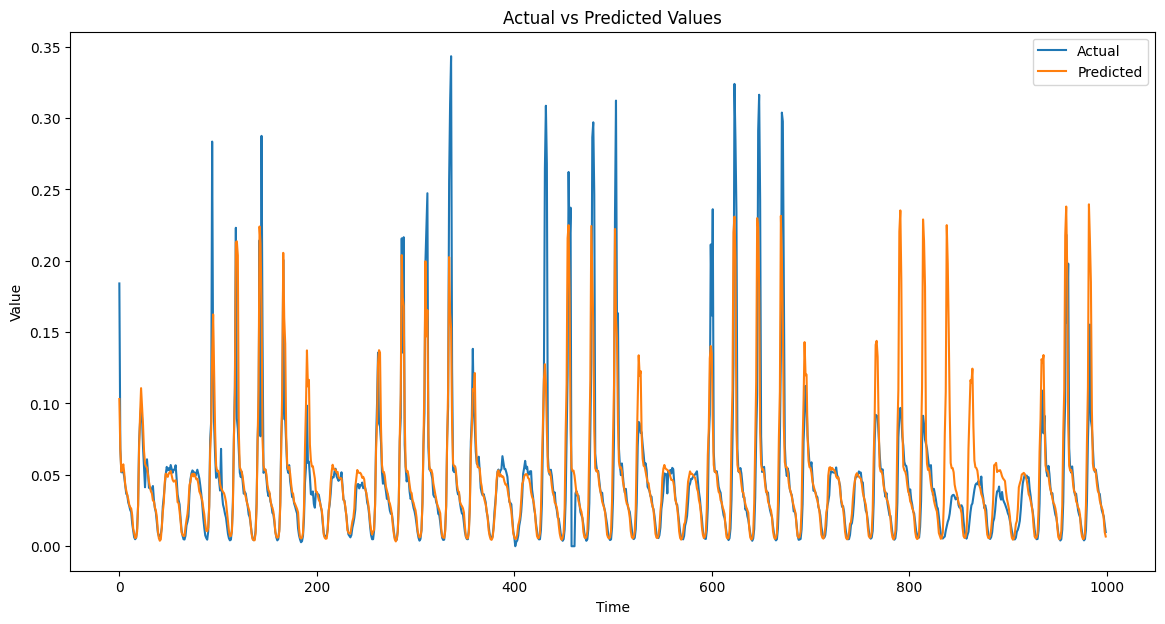

smape: 25.8005%
rmse: 0.0322


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['X'].tolist(), label='Actual')
plt.plot(forecast_df['Forecast'].tolist(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


# Calculating MAPE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['X'].tolist(), forecast_df['Forecast'].tolist()))
# Calculating SMAPE (Symmetric Mean Absolute Percentage Error)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape = symmetric_mean_absolute_percentage_error(test['X'].tolist(), forecast_df['Forecast'].tolist())
print(f'smape: {smape:.4f}%')


print(f'rmse: {rmse:.4f}')

In [20]:
symmetric_mean_absolute_percentage_error(test['X'].tolist()[:-300], forecast_df['Forecast'].tolist()[:-300])

22.712194339453237

# попробуем с часом

In [21]:
df_2 = train2.copy()

# Лаги
lag = 1000
for i in range(1, lag + 1):
    df_2[f'lag_{i}'] = df_2['X'].shift(i)

df_2.dropna(inplace=True)
df_2.reset_index(drop=True, inplace=True)

# Формируем список признаков для обучения, включая только лаги, но не временные признаки
lag_cols = [f'lag_{i}' for i in range(1, lag + 1)]
time_cols = ['Hour']  # Временные признаки
feature_cols = lag_cols + time_cols  # Все признаки вместе

In [22]:
X = df_2[feature_cols].values
y = df_2['X'].values

In [23]:
# Обучение модели
model = CatBoostRegressor(iterations=500,
                          learning_rate=0.05,
                          depth=5,
                          task_type="GPU",
                          devices='0',
                          verbose=100)
model.fit(X, y)

0:	learn: 0.0467261	total: 37.7ms	remaining: 18.8s
100:	learn: 0.0169198	total: 2.42s	remaining: 9.57s
200:	learn: 0.0151115	total: 4.77s	remaining: 7.09s
300:	learn: 0.0138711	total: 7.12s	remaining: 4.7s
400:	learn: 0.0128558	total: 9.47s	remaining: 2.34s
499:	learn: 0.0120385	total: 11.8s	remaining: 0us


In [25]:
# Прогнозирование
n_forecast = len(test)
future_dates = pd.date_range(df_2.iloc[-1]['DateTime'] + pd.Timedelta(hours=1), periods=n_forecast, freq='H')

In [26]:
forecast_df = pd.DataFrame({'DateTime': future_dates})

In [27]:
forecast_df['Hour'] = forecast_df['DateTime'].dt.hour
forecast_df['DayOfWeek'] = forecast_df['DateTime'].dt.dayofweek
forecast_df['DayOfMonth'] = forecast_df['DateTime'].dt.day
forecast_df['Month'] = forecast_df['DateTime'].dt.month

future_time_features = forecast_df[time_cols].values

In [28]:
future_time_features[0]

array([8], dtype=int32)

In [29]:
predictions = []

# Получаем последние значения для лагов и временных признаков
last_value = df_2.iloc[-1]['X']
last_lags = df_2.iloc[-1][lag_cols].values  # Лаги
last_time_features = df_2.iloc[-1][time_cols].values  # Временные признаки

# Входные данные для прогноза (включаем только лаги и фиксированные временные признаки)
lags_features = np.concatenate(([last_value], last_lags[:-1]))
current_input = forecast_input.copy()

# Прогнозирование на будущее
for i in range(n_forecast):
    current_input = np.concatenate((lags_features, future_time_features[i]))
    
    pred = model.predict(current_input.reshape(1, -1))
    predictions.append(pred[0])

    # Обновление входных данных, только для лагов, без изменения временных признаков
    lags_features = np.concatenate(([pred[0]], lags_features[1:]))  # Обновляем лаги

In [30]:
forecast_df['Forecast'] = predictions

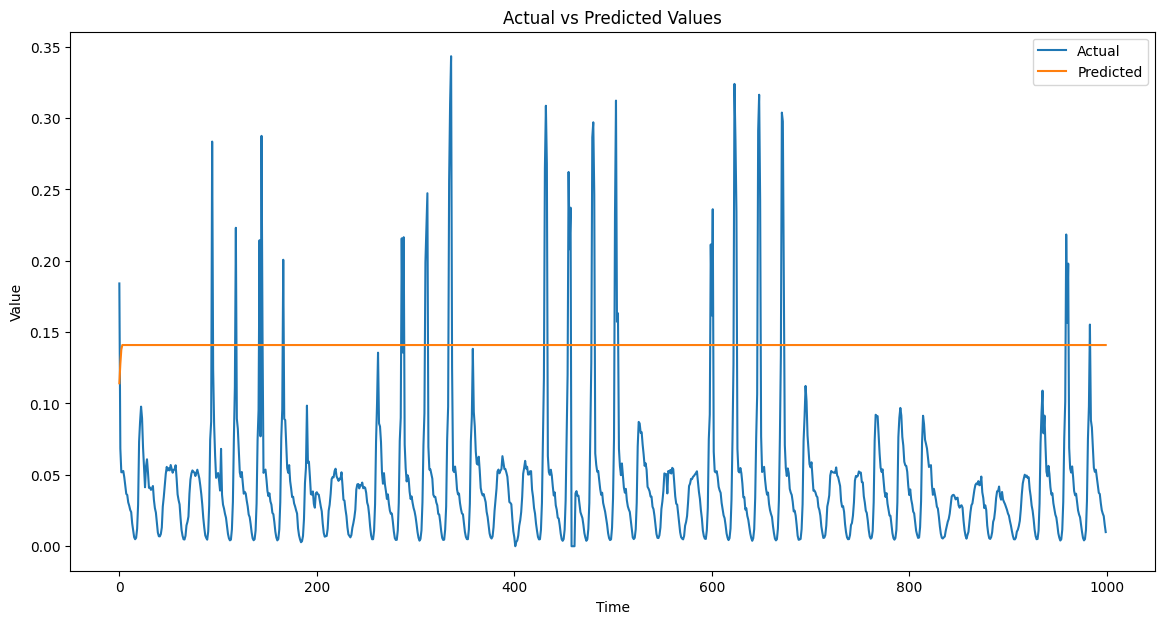

MAPE: 0.11


In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['X'].tolist(), label='Actual')
plt.plot(forecast_df['Forecast'].tolist(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


# Calculating MAPE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['X'].tolist(), forecast_df['Forecast'].tolist()))
print(f'MAPE: {rmse:.2f}')

# Rofl

In [ ]:
import timesfm

tfm = timesfm.TimesFm(
    context_len=<context>,
    horizon_len=<horizon>,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=<backend>,
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")
